##  Taxi Orders Forecast for Git

Company "Chotenkoe Taxi" has collected historical data on taxi orders at airports. To attract more drivers during peak load periods, it is necessary to forecast the number of taxi orders for the next hour. Build a model for such prediction.
The RMSE metric value on the test set should be no more than 48.






In [22]:
import pandas as pd
import os
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from sklearn.dummy import DummyRegressor

In [23]:
pth1 = '/datasets/taxi.csv'
pth2 = 'C:/Users/n.kirpichnikov/Desktop/Apprenticeship/Projects/Time series/taxi.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1,index_col=[0], parse_dates=[0] )
elif os.path.exists(pth2):
    data = pd.read_csv(pth2, index_col=[0], parse_dates=[0])
else:
    print('Something is wrong')

Let's check if the records in the table are in chronological order.

In [24]:
print(data.index.is_monotonic)

True


In [25]:
data.sort_index(inplace=True)

In [26]:
display(data)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [27]:
data.isna().mean()

num_orders    0.0
dtype: float64

Let's check for the presence of duplicates.

In [28]:
data.reset_index().duplicated(['datetime']).sum()

0

## Exploratory Data Analysis

### Resampling by one hour

In [29]:
data=data.resample('1H').sum()

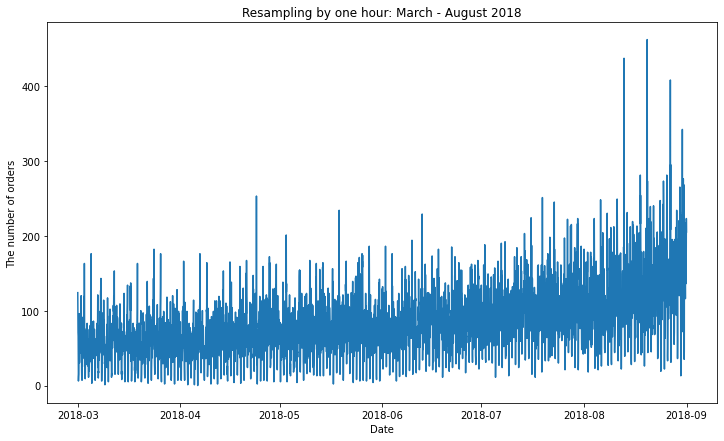

In [30]:
plt.figure(figsize=(12, 7))
plt.plot(data)
plt.title('Resampling by one hour: March - August 2018')
plt.xlabel("Date")
plt.ylabel("The number of orders")
plt.show()

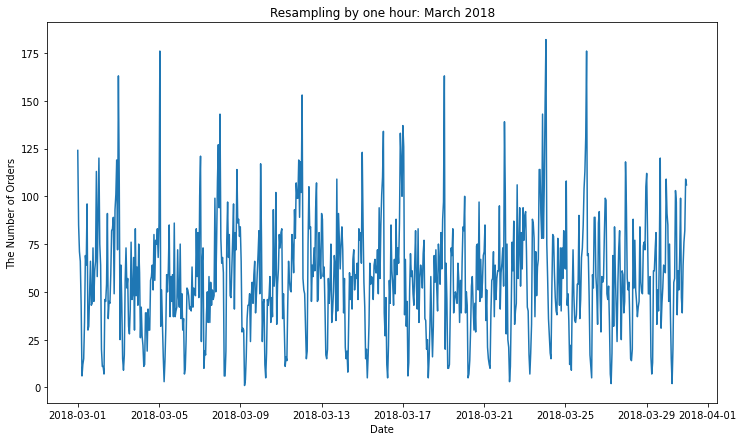

In [31]:
plt.figure(figsize=(12,7))
plt. plot(data['2018-03-01':'2018-03-30'])
plt.title('Resampling by one hour: March 2018')
plt.xlabel("Date")
plt.ylabel("The Number of Orders")
plt.show()

Let's take a closer look at the dynamics throughout the week from Monday to Sunday in March.

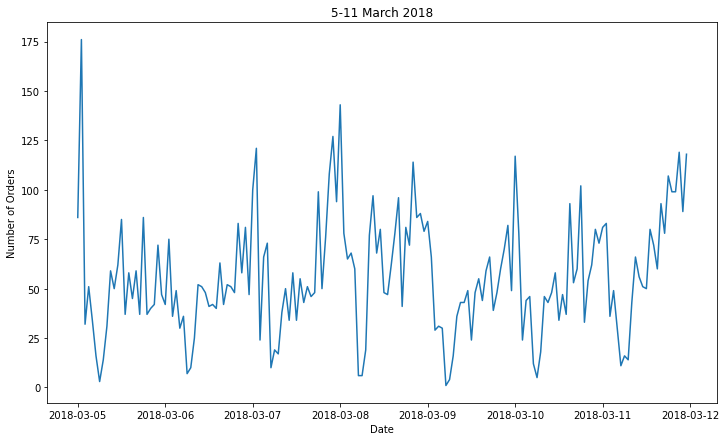

In [32]:
plt.figure(figsize=(12, 7))
plt.plot(data['2018-03-05':'2018-03-11'])
plt.title('5-11 March 2018')
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.show()

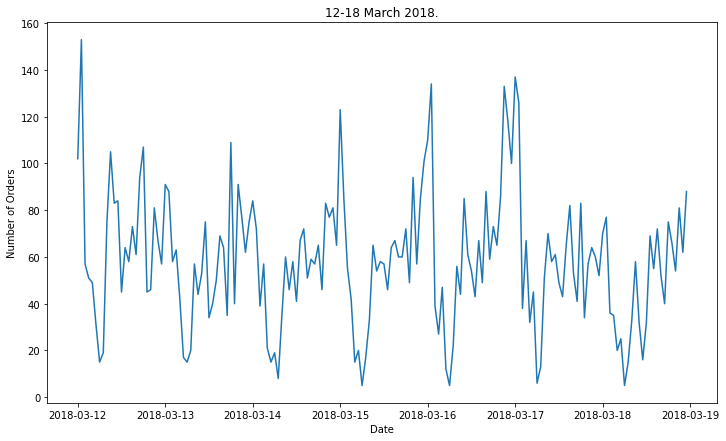

In [33]:
plt.figure(figsize=(12, 7))
plt.plot(data['2018-03-12':'2018-03-18'])
plt.title ('12-18 March 2018.')
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.show()

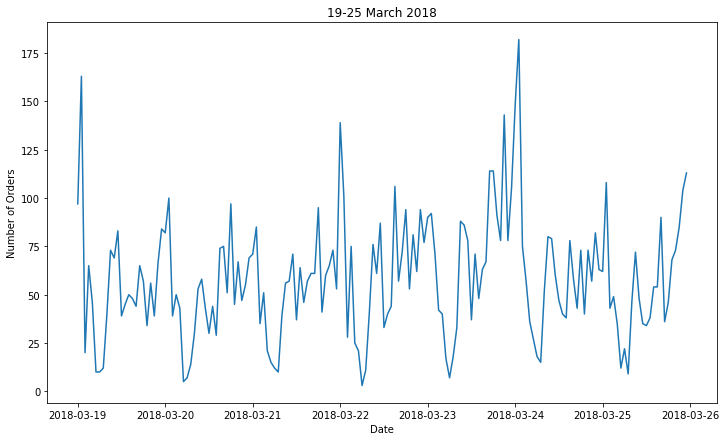

In [34]:
plt.figure(figsize=(12,7))
plt.plot(data['2018-03-19':'2018-03-25'])
plt.title('19-25 March 2018')
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.show()

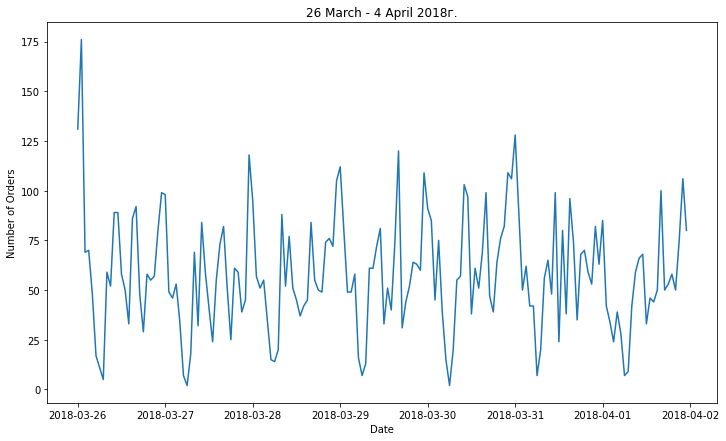

In [35]:
plt.figure(figsize=(12, 7))
plt.plot(data['2018-03-26':'2018-04-01'])
plt.title('26 March - 4 April 2018г.')
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.show()

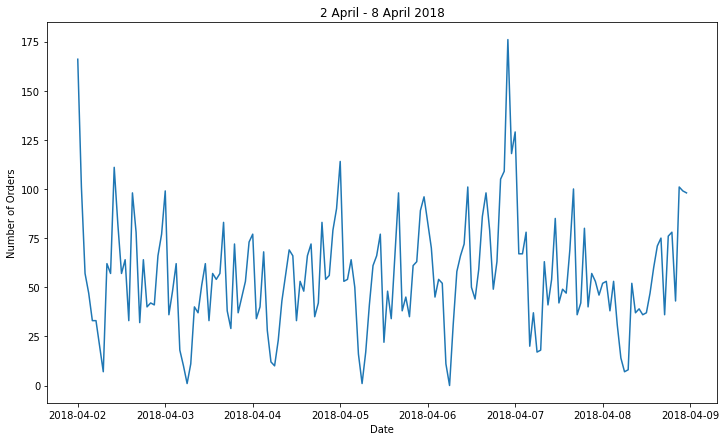

In [36]:
plt.figure(figsize=(12,7))
plt.plot(data['2018-04-02':'2018-04-08'])
plt.title('2 April - 8 April 2018')
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.show()

We can see that the number of orders is approximately the same throughout the week (with some exceptions). There is no clear pattern or dependence on the day of the week. However, a daily seasonality is evident. Let's take a closer look at the dynamics throughout the day in different months.

Let's examine the dynamics during the weekends.

Weekend in May - 26.05.2018

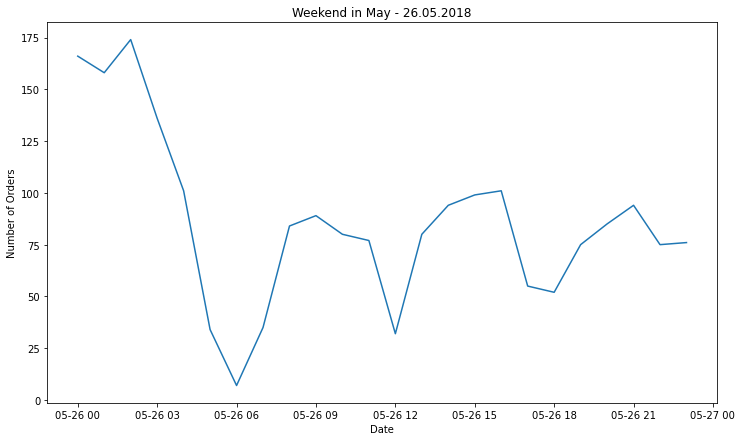

In [37]:
plt.figure(figsize=(12,7))
plt.plot(data['2018-05-26':'2018-05-26'])
plt.title('Weekend in May - 26.05.2018')
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.show()

Weekend in August - 18.08.2018

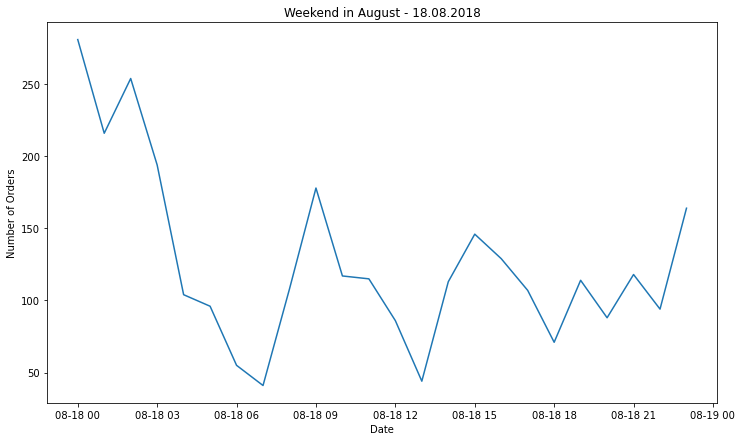

In [38]:
plt.figure(figsize=(12,7))
plt.plot(data['2018-08-18':'2018-08-18'])
plt.title('Weekend in August - 18.08.2018')
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.show()

We can observe a similar pattern across the months and some regularity. During the weekends, the highest activity is observed during the late night hours from 0 to 3, followed by fluctuations throughout the day with slight deviations from the average level of orders.

Let's examine the dynamics during working days.

A working day in May on the date 15.05.2018

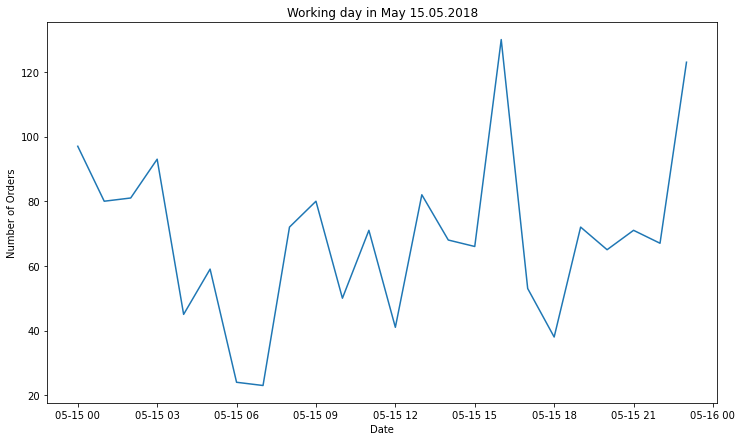

In [39]:
plt.figure(figsize=(12,7))
plt.plot(data['2018-05-15':'2018-05-15'])
plt.title('Working day in May 15.05.2018')
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.show()

A working day in August on the date 15.08.2018.

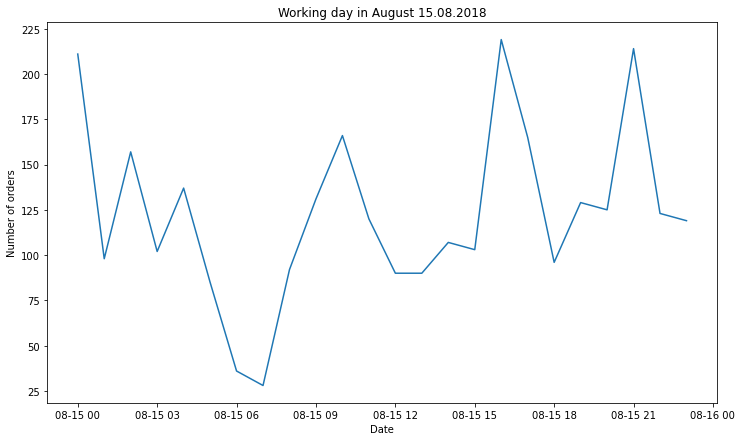

In [40]:
plt.figure(figsize=(12,7))
plt.plot(data['2018-08-15':'2018-08-15'])
plt.title('Working day in August 15.08.2018')
plt.xlabel("Date")
plt.ylabel("Number of orders")
plt.show()

We can observe a similar pattern across the months and some regularity. On workdays, there is an increase in orders around 17:00, followed by another peak after 21:00. The lowest level of orders is around 6:00 in the morning.

### Seasonal_decompose

The method seasonal_decompose() decomposes a time series into three components: trend, seasonality, and residuals - the component that is not explained by the trend and seasonality, representing the noise. It is not possible to forecast the noise component.

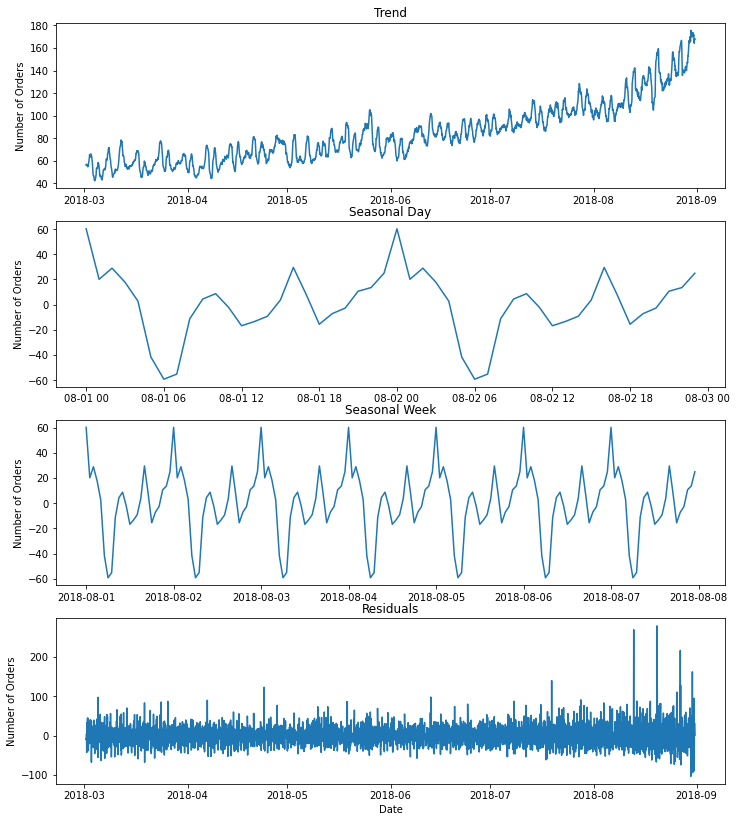

In [41]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(12, 14))
plt.subplot(4,1,1) #the figure has 4 rows, 1 column, and this plot is the first plot.
plt.plot(decomposed.trend)
plt.title('Trend') 
plt.ylabel("Number of Orders")
plt.subplot(4,1,2)
plt.plot(decomposed.seasonal['2018-08-01':'2018-08-02'])
plt.title('Seasonal Day') 
plt.ylabel("Number of Orders")
plt.subplot(4,1,3)
plt.plot(decomposed.seasonal['2018-08-01':'2018-08-07'])
plt.title('Seasonal Week')  
plt.ylabel("Number of Orders")
plt.subplot(4,1,4)
plt.plot(decomposed.resid)
plt.title('Residuals') 
plt.ylabel("Number of Orders")
plt.xlabel("Date");

These plots clearly show that there is a trend - a smooth increase in orders from March to August. Additionally, there is daily seasonality with the lowest level of orders at 6 AM and a peak in orders at midnight. No weekly seasonality is observed. The series appears to be more stationary throughout the week.

### Stationarity

Non-stationary time series are more challenging to forecast because their properties change rapidly over time. The lack of stationarity implies that the mean, variance, or other statistical properties of the series are not constant, making it more difficult to establish consistent patterns or trends. Forecasting non-stationary time series requires additional techniques to address the changing nature of the data.

Let's conduct the Dickey-Fuller test (ADF test) to evaluate the stationarity of the time series

In [42]:
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(data['num_orders'])
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

ADF test statistic: -3.068924289027936
ADF p-values: 0.028940051402614502
ADF number of lags used: 30
ADF number of observations: 4385
ADF critical values: {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
ADF best information criterion: 41728.71357827463


The null hypothesis of the Dickey-Fuller test is that the time series is non-stationary. Since the p-value is 0.02 (at a significance level of 0.01), we fail to reject the null hypothesis. Therefore, the time series is non-stationary. This finding is also supported by the earlier discussed plots, which show clear presence of trend and seasonality. Additionally, the residual plot exhibits significant spikes, indicating non-stationarity as well.

Let's plot the moving average graph. If the mean remains constant over time, the series is stationary. If the mean changes, the series is non-stationary.

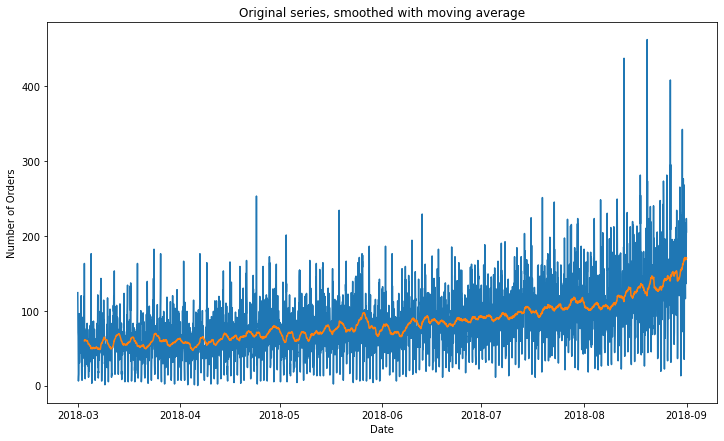

In [43]:
plt.figure(figsize=(12, 7))
data['rolling_mean']=data['num_orders'].shift().rolling(48).mean()
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.title('Original series, smoothed with moving average')  
plt.plot(data)
plt.show()

We can see that the moving average changes, with an increasing trend towards the end. Therefore, the series is non-stationary.

## Model Training

### Feature Engineering

In this task, we don't have any features other than the target variable. Let's take time as our feature (x). We can create two additional features: day of the week (as we noticed that weekdays and weekends have different dynamics) and hour of the day (as there is hourly seasonality).

To make the series stationary, we can calculate the differences between its values. The differences of a time series are often more stationary than the original series.

In [47]:
def make_features(data, max_lag, rolling_mean_size):
    data_features = data.copy()
   
    data_features['dayofweek'] = data.index.dayofweek
    data_features['hour'] = data.index.hour
    for lag in range (1, max_lag+1):
        data_features['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data_features['rolling_mean']=data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_features

In [48]:
data_new = make_features(data, 24, 48)

In [49]:
print(data_new)

                     num_orders  rolling_mean  dayofweek  hour  lag_1  lag_2  \
datetime                                                                       
2018-03-01 00:00:00         124           NaN          3     0    NaN    NaN   
2018-03-01 01:00:00          85           NaN          3     1  124.0    NaN   
2018-03-01 02:00:00          71           NaN          3     2   85.0  124.0   
2018-03-01 03:00:00          66           NaN          3     3   71.0   85.0   
2018-03-01 04:00:00          43           NaN          3     4   66.0   71.0   
...                         ...           ...        ...   ...    ...    ...   
2018-08-31 19:00:00         136    170.895833          4    19  207.0  217.0   
2018-08-31 20:00:00         154    170.208333          4    20  136.0  207.0   
2018-08-31 21:00:00         159    169.437500          4    21  154.0  136.0   
2018-08-31 22:00:00         223    169.208333          4    22  159.0  154.0   
2018-08-31 23:00:00         205    170.1

### Splitting into datasets (train, validation, test)

In [50]:
train, test=train_test_split(data_new, shuffle=False, test_size=0.1)

In [51]:
print (train.index.min(), train.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00


In [52]:
print (test.index.min(), test.index.max())

2018-08-13 14:00:00 2018-08-31 23:00:00


In [53]:
train=train.dropna()

In [54]:
test=test.dropna()

In [55]:
features_train=train.drop(['num_orders'], axis=1)

In [56]:
target_train=train['num_orders']

In [57]:
features_test=test.drop(['num_orders'], axis=1)

In [58]:
target_test=test['num_orders']

In [59]:
model_data = pd.DataFrame(columns=('model','fit_time','score_time','RMSE'))
model_data.head()

,model,fit_time,score_time,RMSE


### Linear Regresion

In [60]:
model_lr=LinearRegression()

In [61]:
tscv=TimeSeriesSplit(n_splits=3)

In [62]:
cv_lr= cross_validate(model_lr, features_train, target_train, cv=tscv, scoring='neg_root_mean_squared_error')
fit_time = cv_lr['fit_time'].mean()
score_time = cv_lr['score_time'].mean()
test_score = abs(cv_lr['test_score'].mean())

In [63]:
lr_data = ['LinearRegression', fit_time, score_time, test_score]

#add to dataframe
model_data.loc[len(model_data)] = lr_data
model_data.head()

,model,fit_time,score_time,RMSE
0,LinearRegression,0.009059,0.0,28.236083


### Random Forest

In [64]:
model_rf=RandomForestRegressor()

In [65]:
param = {'max_depth':[2,3,4,5,6,7],
        'n_estimators':[100,200,300]}

In [66]:
rf_grid=GridSearchCV(estimator=model_rf, cv=tscv, param_grid = param, scoring='neg_root_mean_squared_error', n_jobs=-1)
rf_grid=rf_grid.fit(features_train, target_train)

In [68]:
results = rf_grid.cv_results_
best_index = rf_grid.best_index_

In [69]:
fit_time = results['mean_fit_time'][best_index]
score_time = results['mean_score_time'][best_index]
RMSE = (rf_grid.best_score_*-1)

In [70]:
rf_data = ['random_forest_grid', fit_time, score_time, RMSE]

model_data.loc[len(model_data)] = rf_data
model_data.head()

,model,fit_time,score_time,RMSE
0,LinearRegression,0.009059,0.000000,28.236083
1,random_forest_grid,3.134317,0.035054,27.724306


### LightGBM

In [71]:
model_lgb= LGBMRegressor()

In [72]:
param = {'n_estimators': [100, 200, 300], 
         'max_depth':[2,3,4,5,6,7],
         'learning_rate':[0.01, 0.05, 0.03, 0.1, 0.3, 0.5]
        }

In [73]:
gs = GridSearchCV(estimator=model_lgb,cv=tscv, param_grid=param,scoring='neg_root_mean_squared_error')

In [74]:
lgb_grid= gs.fit(features_train, target_train)

In [75]:
results = lgb_grid.cv_results_

best_index = lgb_grid.best_index_


fit_time = results['mean_fit_time'][best_index]
score_time = results['mean_score_time'][best_index]
RMSE = (lgb_grid.best_score_*-1)


In [76]:
lgbm_data = ['light_gbm_grid', fit_time, score_time, RMSE]

model_data.loc[len(model_data)] = lgbm_data
model_data.head()

,model,fit_time,score_time,RMSE
0,LinearRegression,0.009059,0.000000,28.236083
1,random_forest_grid,3.134317,0.035054,27.724306
2,light_gbm_grid,0.041657,0.000000,26.003900


### Сatboost

In [77]:
model_cbr = CatBoostRegressor()

In [78]:
grid_parameters = {'depth'         : [6,8,10],
                  'learning_rate' : [0.01, 0.05, 0.1],
                  'iterations'    : [900, 1000, 1100]
                 }

In [79]:
cbr_grid = GridSearchCV(estimator=model_cbr, param_grid = grid_parameters, cv = tscv, n_jobs=-1, scoring='neg_root_mean_squared_error' )


In [80]:
cbr_grid.fit(features_train, target_train)

0:	learn: 37.7827946	total: 137ms	remaining: 2m 3s
1:	learn: 36.9591731	total: 140ms	remaining: 1m 2s
2:	learn: 36.1186185	total: 144ms	remaining: 42.9s
3:	learn: 35.3763900	total: 147ms	remaining: 32.9s
4:	learn: 34.6711075	total: 150ms	remaining: 26.9s
5:	learn: 34.0031022	total: 154ms	remaining: 22.9s
6:	learn: 33.3433570	total: 157ms	remaining: 20s
7:	learn: 32.7785788	total: 160ms	remaining: 17.9s
8:	learn: 32.2079973	total: 164ms	remaining: 16.2s
9:	learn: 31.6898705	total: 167ms	remaining: 14.8s
10:	learn: 31.1633541	total: 170ms	remaining: 13.8s
11:	learn: 30.7064212	total: 174ms	remaining: 12.8s
12:	learn: 30.3037195	total: 177ms	remaining: 12.1s
13:	learn: 29.9290317	total: 181ms	remaining: 11.4s
14:	learn: 29.5534661	total: 184ms	remaining: 10.9s
15:	learn: 29.2112454	total: 187ms	remaining: 10.3s
16:	learn: 28.8270702	total: 191ms	remaining: 9.91s
17:	learn: 28.4640560	total: 194ms	remaining: 9.52s
18:	learn: 28.1765747	total: 198ms	remaining: 9.16s
19:	learn: 27.8601589	to

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x0000029170B259D0>,
             n_jobs=-1,
             param_grid={'depth': [6, 8, 10], 'iterations': [900, 1000, 1100],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='neg_root_mean_squared_error')

In [81]:
results = cbr_grid.cv_results_

best_index = cbr_grid.best_index_


fit_time = results['mean_fit_time'][best_index]
score_time = results['mean_score_time'][best_index]
RMSE = (cbr_grid.best_score_*-1)

In [82]:
catboost_data = ['CatBoost', fit_time, score_time, RMSE]

model_data.loc[len(model_data)] = catboost_data
model_data.head()

,model,fit_time,score_time,RMSE
0,LinearRegression,0.009059,0.000000,28.236083
1,random_forest_grid,3.134317,0.035054,27.724306
2,light_gbm_grid,0.041657,0.000000,26.003900
3,CatBoost,12.362878,0.020830,26.062814


 The best result was achieved with light_gbm, so let's conduct testing using this model.

<div class="alert alert-success">
<h2> Комментарий ревьюера v.3 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
Отобрали лучшего кандидата для тестирования на тестовой выборке - отлично!
</div>

## Тестирование

In [83]:
preds_lgb=lgb_grid.predict(features_test)

In [84]:
RMSE = mean_squared_error(preds_lgb, target_test , squared=False)

In [85]:
print(RMSE)

42.39976960515207


We can see that the RMSE for all models is less than 48, which meets the requirements of the task.

In [61]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
preds_dummy=dummy_regr.predict(features_test)
RMSE_dummy = mean_squared_error(preds_dummy, target_test , squared=False)
print(RMSE_dummy)

84.5807770460722


The RMSE of the dummy model is worse than the RMSE of our optimal model, light gbm. This indicates that our efforts were not in vain and our optimal model is sufficiently well-trained.

## Results

We have built a model to predict the number of taxi bookings for the next hour. To do this, we loaded a dataset with historical data on taxi bookings at airports. The dataset contained around 26.5 thousand records with the number of bookings every 10 minutes from March 2018 to August 2018. We performed resampling at an hourly interval. Next, we analyzed the presence of trends and seasonality. We discovered a trend of increasing bookings from March to August, as well as daily seasonality. The highest number of bookings occurred at midnight, and the lowest number of bookings was observed at 6 AM.

Then, we trained four models - linear regression, LightGBM, CatBoost, and Random Forest - with parameter tuning. Prior to that, we created features from the timestamp, namely day of the week and hour. We set the lag and rolling mean to 24 and 48, respectively. With these parameters, LightGBM emerged as the best-performing model. On the test set, it achieved an RMSE of 42.39, which satisfies the task requirements.





